<a href="https://colab.research.google.com/github/muryulia/Bauman-Moscow-State-Technical-University-Data-Analyst-Data-Scientist-Course/blob/main/Final_Project_Welding_Murtazina_Yuliya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения


## 1 Описание задачи

Требуется провести прогнозирование глубины (Depth) и ширины (Width) сварного шва в зависимости от параметров технологического процесса.

### 1.1. Описание данных

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала.

Датасет содержит следующие параметры технологического процесса:
- IW - величина сварочного тока;
- IF - ток фокусировки электронного пучка;
- VW - скорость сварки;
- FP - расстояние от поверхности образцов до электронно-оптической системы. 

По совокупности параметров технологических режимов обеспечивались минимально возможные размеры сварных швов: глубина шва (Depth) и ширина шва (Width).

В процессе выполнения работ была произведена электронно-лучевая сварка 18-ти единиц образцов. Результаты металлографического контроля по размерам сварного шва для каждого образца проводились в 4-х поперечных сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне 19,8 – 20 кВ. 

Набор полученных данных собран в составе режимов сварки, размеров сварочных швов в поперечных сечениях всех образцов.

## 2 Предобработка данных

In [1]:
! pip install phik --quiet
!pip install catboost --quiet
!pip install scikeras --quiet

     |████████████████████████████████| 690 kB 16.4 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


Сделаем импорт необходимых библиотек и посмотрим на данные.

In [77]:
#Загрузим необходимые библиотеки
import pandas as pd
import numpy as np

import requests

import re
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.neural_network import MLPRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

import scikeras
from scikeras.wrappers import KerasRegressor

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from catboost import CatBoostRegressor

from scipy import stats as st

import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(rc={'figure.figsize': (20, 15)})
sns.set_theme(style='white', palette=None)
sns.set_context('talk')
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_colwidth=None

In [3]:
# Прочитаем данные из файла
try:
  df_orig = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ebw_data.csv')
except:
   print('Check the path to the file')
df_orig.head()  

,IW,IF,VW,FP,Depth,Width
0,47,139,4.50,80,1.60,2.54
1,47,139,4.50,80,1.62,2.50
2,47,139,4.50,80,1.68,2.60
3,47,139,4.50,80,1.58,2.52
4,45,140,4.50,80,1.76,2.48


In [4]:
df_orig.shape

(72, 6)

In [5]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [6]:
df_orig.describe()

,IW,IF,VW,FP,Depth,Width
count,72.00,72.00,72.00,72.00,72.00,72.00
mean,45.67,141.33,8.64,78.33,1.20,1.97
std,1.68,5.15,2.06,21.49,0.23,0.28
min,43.00,131.00,4.50,50.00,0.80,1.68
25%,44.00,139.00,8.00,60.00,1.08,1.76
50%,45.50,141.00,9.00,80.00,1.20,1.84
75%,47.00,146.00,10.00,80.00,1.29,2.05
max,49.00,150.00,12.00,125.00,1.76,2.60


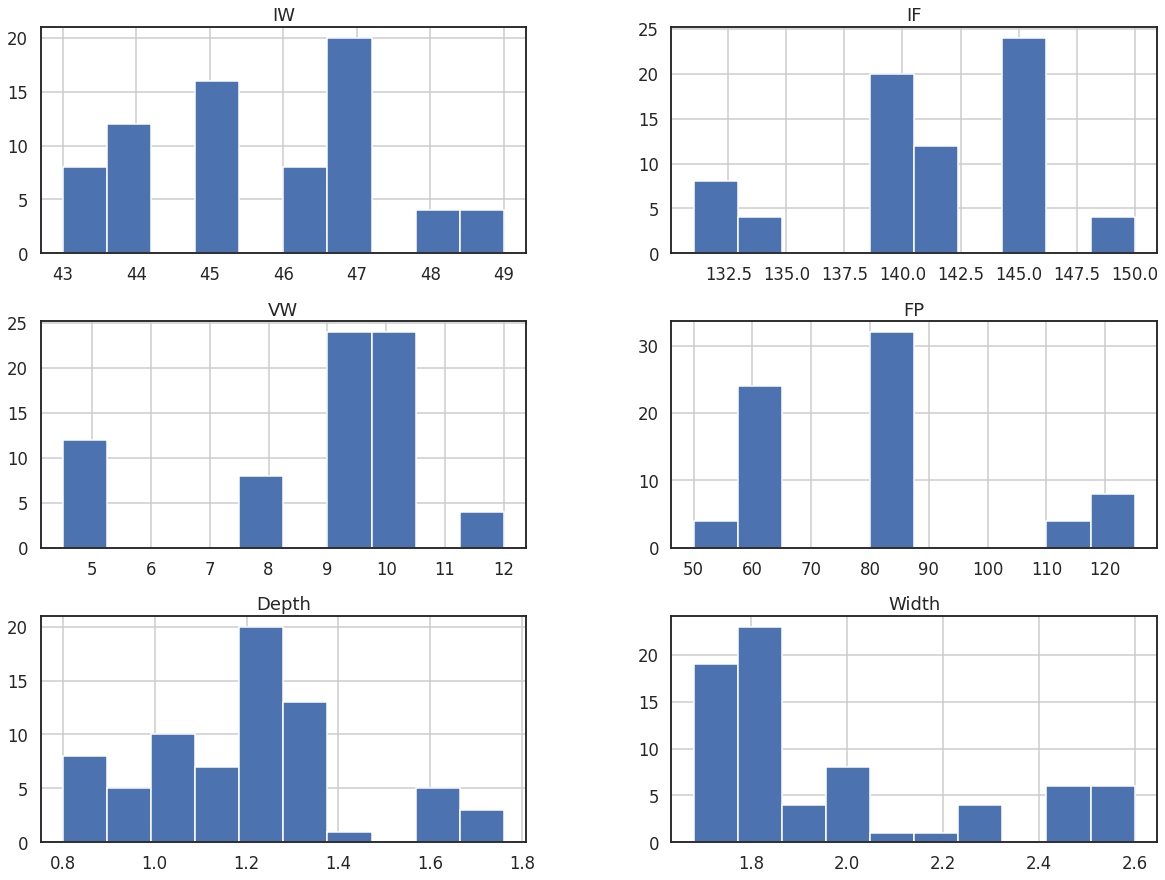

In [7]:
cols = df_orig.columns.to_list()
df_orig[cols].hist(figsize=(20, 15));

Датасет состоит из 72 строк и 6 столбцов. Типы данных - вещественные и целочисленные. 

Стастистические показатели датасеты и их графическое представление приведены выше.

Проверим данные на наличие пропусков и дубликатов.

In [8]:
df_orig.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

Пропусков в данных нет.

In [9]:
df_orig.duplicated().sum()

7

В данных присутствует 7 дубликатов, посмотрим на них.

In [10]:
df_orig[df_orig.duplicated()]

,IW,IF,VW,FP,Depth,Width
11,45,140,8.00,80,1.20,1.96
31,47,139,4.50,80,1.36,2.48
46,46,146,10.00,60,1.36,1.76
54,43,150,9.00,50,1.08,1.82
55,43,150,9.00,50,1.08,1.82
59,44,146,9.00,60,1.20,1.76
70,45,146,9.00,60,1.28,1.76


Удалим дубликаты из таблицы. Сохраним данные без дубликатов в новый датафрейм.

In [11]:
df = df_orig.drop_duplicates()
df.duplicated().sum()

0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      65 non-null     int64  
 1   IF      65 non-null     int64  
 2   VW      65 non-null     float64
 3   FP      65 non-null     int64  
 4   Depth   65 non-null     float64
 5   Width   65 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.6 KB


Предобработка данных закончена. После предобработки размер датасета составляет 65 строк и 6 столбцов.

## 3 Исследовательский анализ данных (EDA)

Посмотрим, есть ли в данных выбросы. Построим бокс-плот для каждого столбца.

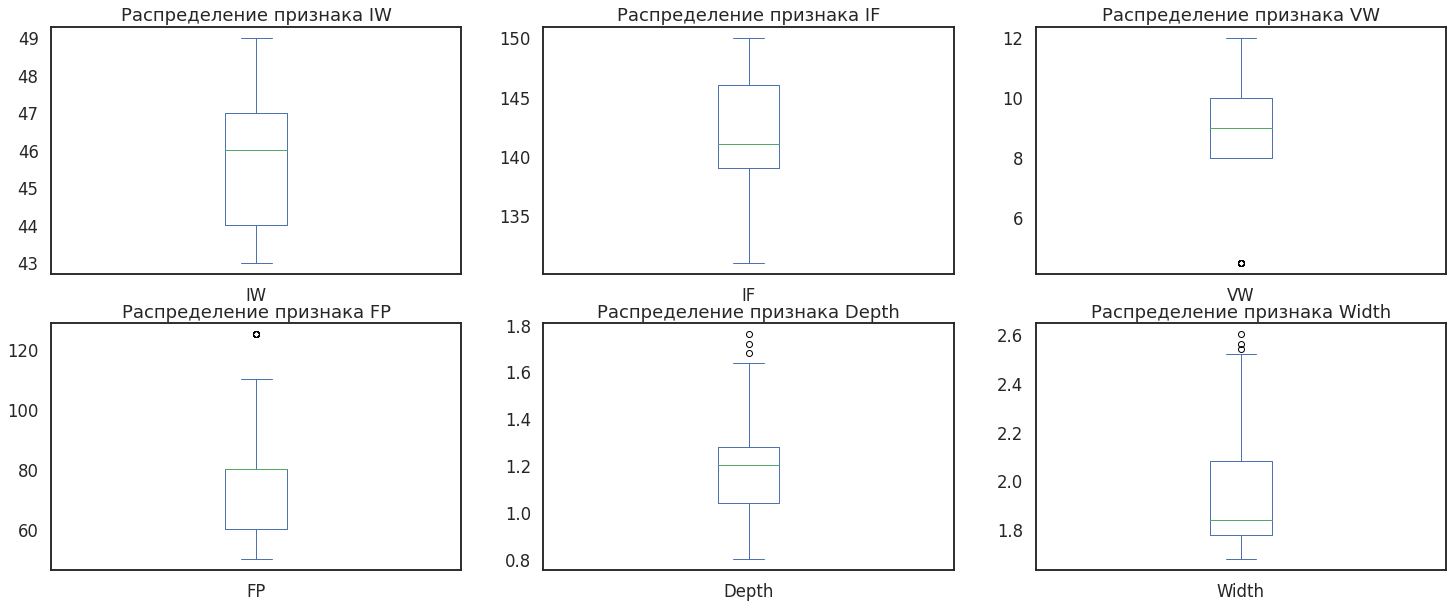

In [13]:
for i, col in enumerate(df.columns.to_list()):
    df[col].plot(
    kind='box',
    grid=False, 
    title='Распределение признака ' + col, 
    #alpha=0.7,
    figsize=(25,10),
    ax=plt.subplot(2, 3, i + 1),); 

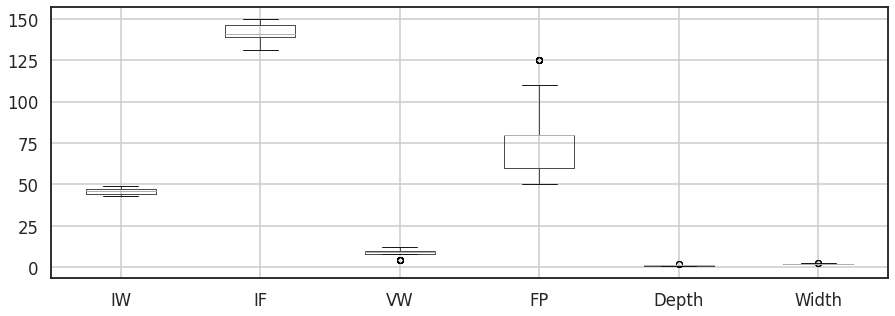

In [14]:
cols = df.columns.to_list()
df[cols].boxplot(figsize=(15, 5));

В четырех столбцах есть выбросы. Чтобы оценить, насколько они влияют на выборку, воспользуемся правилом трех сигм: значения выборки, отстоящие от математического ожидания меньше, чем на три сигмы, принадлежат тому же распределению, а значения выборки, отстоящие от математического ожидания больше, чем на три сигмы, принадлежат другому распределению.

Чтобы найти количество отклонений от среднего значения, рассчитаем z-оценку.

Выведем результаты на визуализации.



In [15]:
def plot_hist(x, title='', xlabel=''):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Количество')
    plt.hist(x, bins = 30)

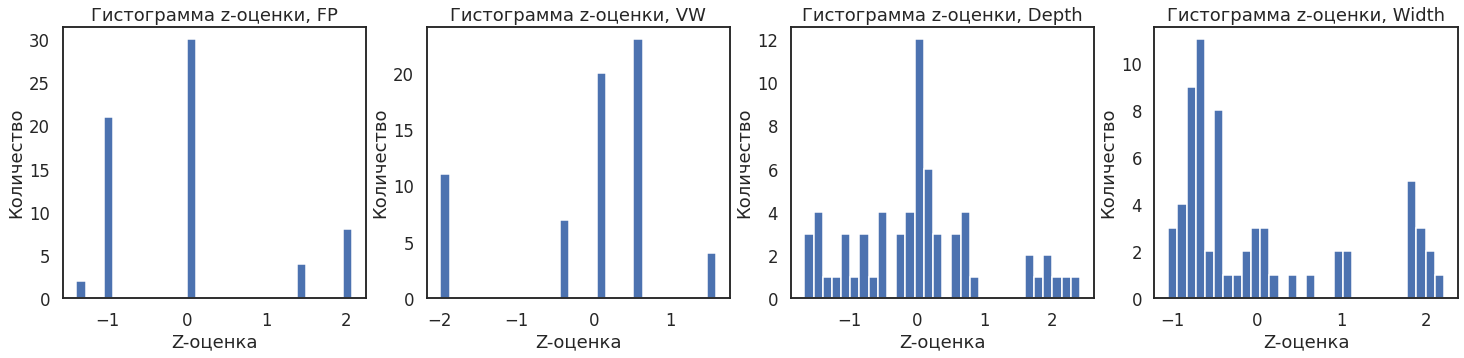

In [16]:
cols = ['FP', 'VW', 'Depth', 'Width']
plt.figure(figsize=(25,5))
for i, col in enumerate(cols):
  z_value = (df[col] - df[col].mean()) / df[col].std()
  ax = plt.subplot(1, 4, i + 1)
  plot_hist(z_value, title="Гистограмма z-оценки, " + col, xlabel="Z-оценка")

Отклонения от среднего значения не превышают трех сигм, поэтому данные, похожие на выбросы, можно считать частью одного распределения. Мы не будем их удалять из датасета.

Построим матрицу попарного сравнения признаков.

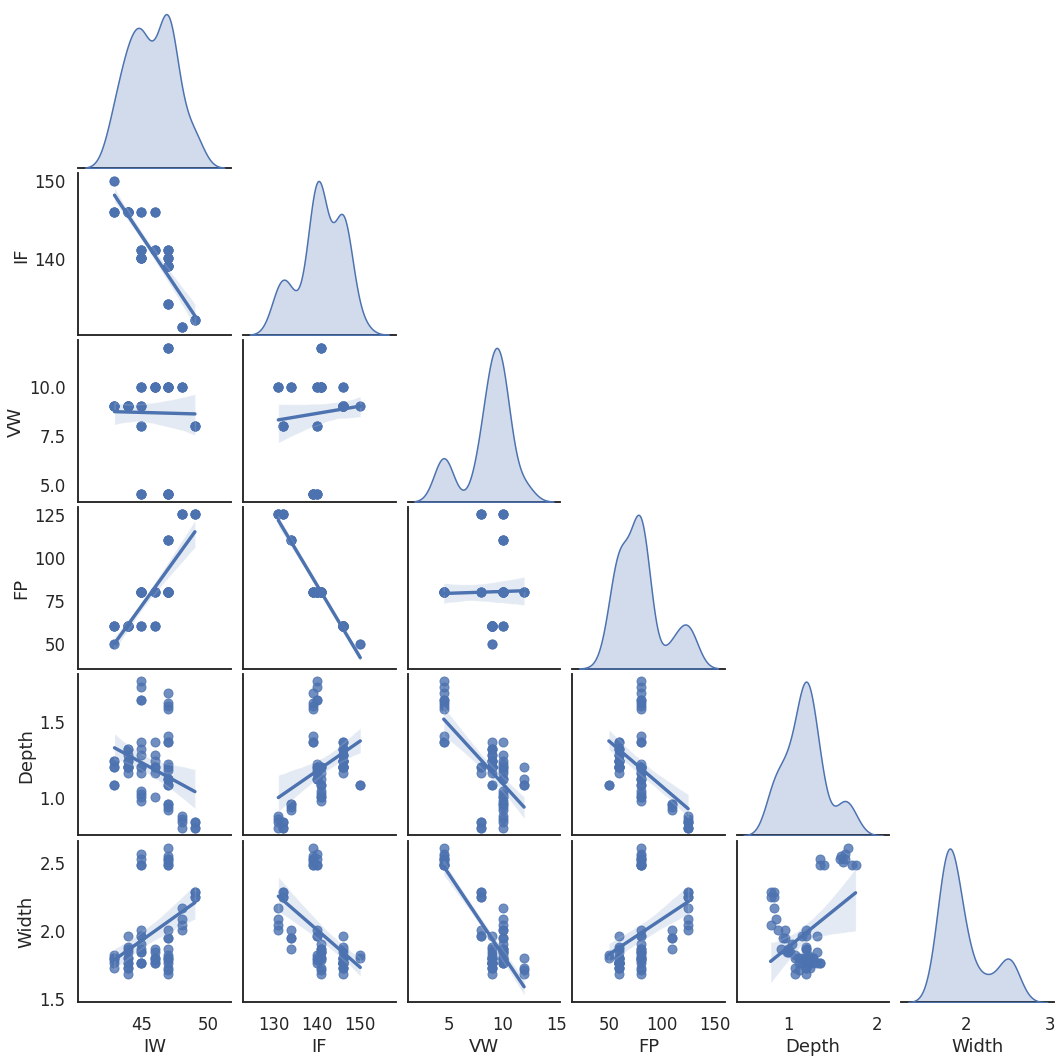

In [17]:
sns.pairplot(df, corner=True, kind='reg', diag_kind='kde');

Из диаграммы видно, что разные технологические параметры по-разному влияют на глубину и толщину шва. Например, чем больше величина сварочного тока (IW), тем ниже глубина шва, и чем ниже величина сварочного тока, тем меньше ширина шва.

Мы можем выделить такой параметр, как скорость сварки (VW) - значения этого параметра от 7 до 10 единиц позволяют получить наименьшую глубину и толщину шва.

Также на диаграмме явно выделяется кластер швов с большой шириной и глубиной.

Проверим, есть ли какие-то корреляции в данных.

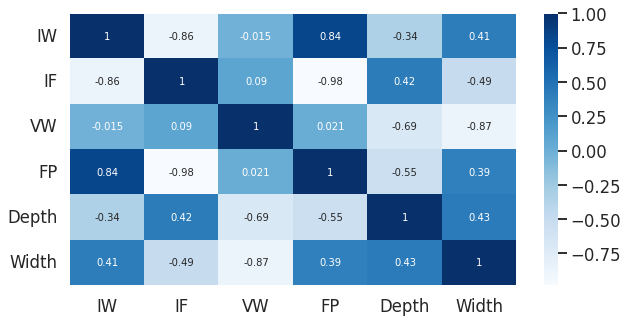

In [18]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, cmap='Blues');

                        Шкала Чеддока
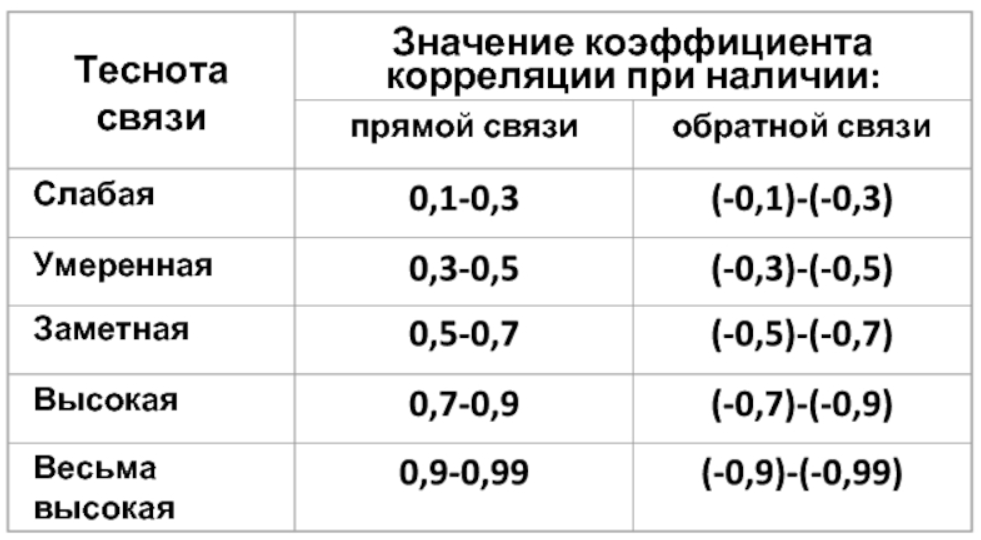

Если исходить из шкалы Чеддока, приведенной выше, то матрица корреляции показывает 
для глубины сварного шва:
- заметную обратную зависимость со скоростью сварки (VW);
- умеренную обратную зависимость с расстоянием от поверхности образцов до электронно-оптической системы (FP) и глубиной шва; 
- умеренную зависимость с током фокусировки электронного пучка (IF);
для ширина сварного шва:
- высокую обратную зависимость со скоростью сварки (VW);
- умеренную обратную зависимость с током фокусировки электронного пучка (IF);
- умеренную зависимость с величиной сварочного тока (IW).

Между собой целевые переменные показывают умеренную корреляцию.
Также можно отметить, что признаки величина сварочного тока (IW) и ток фокусировки электронного пучка (IF) показывают высокую обратную корреляцию между собой и высокую корреляцию с признаком расстояние от поверхности образцов до электронно-оптической системы (FP). 

Возможно, эти признаки не стоит использовать при построении модели.

Проверим наличие нелинейной связи между переменными с помощью критерия PHIK.

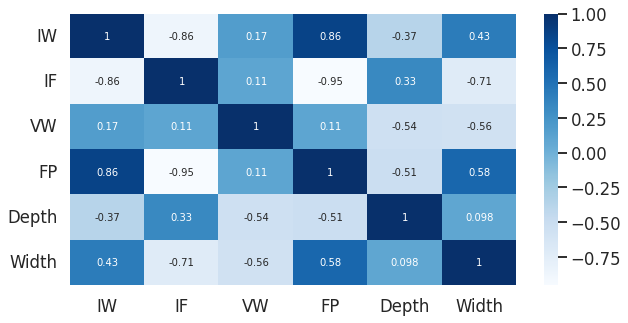

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(method='spearman'),cmap='Blues', annot=True);

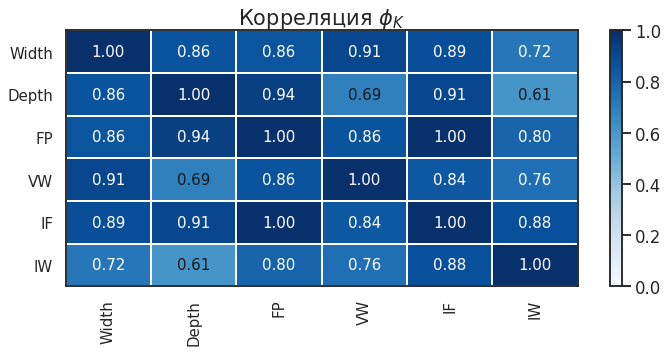

In [20]:
phik_res = df.phik_matrix(interval_cols=[])
plot_correlation_matrix(phik_res.values, 
                        x_labels=phik_res.columns, 
                        y_labels=phik_res.index, 
                        vmin=0, vmax=1, color_map='Blues', 
                        title=r'Корреляция $\phi_K$', 
                        fontsize_factor=1.5, 
                        figsize=(10, 5))
plt.tight_layout()

Мы видим, что в данных есть сильные нелинейные зависимости. Ток фокусировки электронного пучка (IF) показывают корреляцию, равную 1,  с расстоянием от поверхности образцов до электронно-оптической системы (FP). 

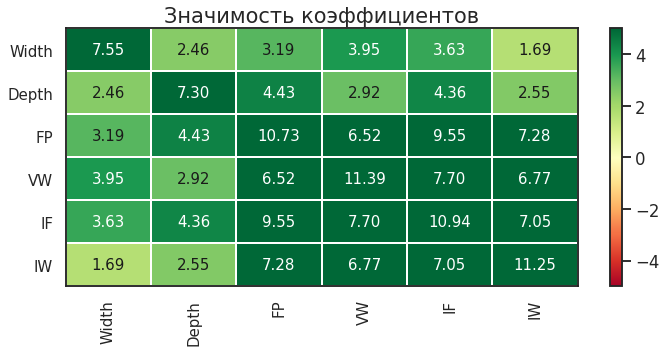

In [21]:
significance_overview = df.significance_matrix(interval_cols=[])
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Значимость коэффициентов", 
                        usetex=False, fontsize_factor=1.5, figsize=(10, 5))
plt.tight_layout()

Все признаки являются статистически значимыми. Наиболее значимым признаком для глубины шва является расстояние от поверхности образцов до электронно-оптической системы (FP), а для ширины шва - скорость сварки (VW). 

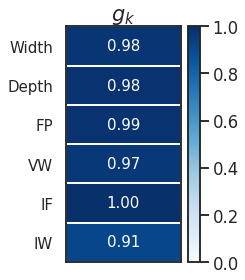

In [22]:
global_correlation, global_labels = df.global_phik(interval_cols=['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'])

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map='Blues', title=r'$g_k$',
                        fontsize_factor=1.5)
plt.tight_layout()

Высокие значения глобальной корреляции для каждого признака говорят о том, что каждый признак можно выразить через другие. А значит, наши целевые значения ширины и глубины сварного шва хорошо поддаются прогнозированию.

## 4 Построение моделей машинного обучения для прогнозирования ширины и глубины сварного шва

У нас есть 4 признака и 2 целевые переменные, значения которых нужно предсказать. Это задача регрессии. Т.к. у нас несколько входных и несколько выходных переменных, то это множественная (входов больше, чем 1) многоцелевая (таргетов больше, чем 1) регрессия.

Для построения такой модели будем использовать следующие алгоритмы машинного обучения:

- линейная регрессия;
- метод опорных векторов;
- метод ближайших соседей;
- случайный лес;
- градиентный бустинг;
- бустинг с помощью алгоритма CatBoost;
- полносвязные нейронные сети.

Для оценки качества модели можно использовать следующие метрики:
- MSE - среднеквадратичная ошибка;
- MAE - средняя абсолютная ошибка;
- $R^2$ - коэффициент детерминации.

Поскольку у нас несколько выходов, то к построению модели можно подойти двумя способами:
- предсказывать каждое выходное значение по отдельности;
- предсказывать сразу два значения с помощью методов MultiOutputRegressor, RegressorChain.

Попробуем каждый подход и выберем лучшую модель.

Начнем с построения пайплайна машинного обучения и выбора параметров для наших моделей.

### 4.1 Пайплайн моделей машинного обучения и подбор гиперпараметров: базовые алгоритмы и ансамбли

Разделим данные на два набора: обучающий и тестовый.

In [23]:
X = df[['IW', 'IF', 'VW', 'FP']].values
y = df[['Depth', 'Width']].values

X.shape, y.shape

((65, 4), (65, 2))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52, 4), (13, 4), (52, 2), (13, 2))

Пайплайн машинного обучения будет выглядеть следующим образом:
- стандартизация данных с помощью метода StandardScaler();
- определение оптимального количества признаков с помощью метода главных компонент (PCA);
- загрузка модели. 

Подберем параметры для выбранных моделей с помощью поиска по сетке.

Необходимо учитывать, что наши данные упорядочены по по испытаниям, поэтому перед кросс-валидацией во время поиска по сетке их нужно перемешать, как это было бы при обычном разделении на трейн и тест. Когда мы делаем поиск по сетке, то оценку качества модели ведем по всему набору данных, и без перемешивания оценка качества работы модели на кросс-валидации будет низкой, потому что модель учится на одних данных, а предсказывает на других данных. 

In [25]:
'''
Функция для перебора параметров по сетке с пайплайном и кроссвалидацией.
Возможен подбор признаков для нескольких таргетов с использованием методов MultiOutputRegressor и Regressor_Chain.
Кросс-валидация производится с предварительным перемешиванием записей.
Принимает на вход признаки, таргеты, тренировочную выборку, предопределенные названия моделей: 'SVR', 'KNeighbors', 'RandomForest', 'GragientBoosting', 'CatBoost'
На выходе получаем название модели, лучшую оценку на кросс-валидации, словарь с лучшими параметрами модели и пайплайн с лучшими параметрами.
'''
def g_search(X, y, model, Multi_Output_Regressor=False, Regressor_Chain=False, n_splits=5, scoring='r2'):
  model_def = ''
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  if model == 'LinearRegression':
    param_grid = {
                  'reduce_dims__n_components': [2, 3],                  
                  }
    model_def = LinearRegression() 
    
  if model == 'SVR':
    param_grid = {
                  'reduce_dims__n_components': [2, 3],
                  'model__C': [0.1, 1, 10, 100],
                  'model__degree': [2, 3, 4, 5],
                  'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                  }
    model_def = SVR(degree=2) 

    if (Multi_Output_Regressor == True):
      param_grid = {
                  'reduce_dims__n_components': [2, 3],
                  'model__estimator__C': [0.1, 1, 10, 100],
                  'model__estimator__degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'model__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                  }

    if Regressor_Chain == True:
      param_grid = {
                  'reduce_dims__n_components': [2, 3],
                  'model__base_estimator__C': [0.1, 1, 10, 100],
                  'model__base_estimator__degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'model__base_estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                  }

  if model == 'KNeighbors':
    param_grid =  {
                    'reduce_dims__n_components': [2, 3],
                    'model__n_neighbors': [2, 3, 4, 5],
                    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'model__weights': ['uniform', 'distance'],
                    'model__leaf_size': [5, 10, 20],
                   }    
    model_def =  KNeighborsRegressor(n_neighbors=7, algorithm='ball_tree', leaf_size=20, weights='distance')  
    if (Multi_Output_Regressor == True):
      param_grid = {
                    'reduce_dims__n_components': [2, 3],
                    'model__estimator__n_neighbors': [2, 3, 4, 5],
                    'model__estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'model__estimator__weights': ['uniform', 'distance'],
                    'model__estimator__leaf_size': [5, 10, 20],
                  }

    if Regressor_Chain == True:
      param_grid = {
                    'reduce_dims__n_components': [2, 3],
                    'model__base_estimator__n_neighbors': [2, 3, 4, 5],
                    'model__base_estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'model__base_estimator__weights': ['uniform', 'distance'],
                    'model__base_estimator__leaf_size': [5, 10, 20],
                  }

  if model == 'RandomForest':
    param_grid = {
        'reduce_dims__n_components': [2, 3],
        'model__n_estimators': [100, 150, 200],
        'model__criterion': ['squared_error', 'absolute_error', 'poisson'],
        'model__max_features': ['auto', 'sqrt', 'log2'],
        'model__max_samples': [5, 10, 20],
                    }

    model_def = RandomForestRegressor(n_estimators=200, max_features ='sqrt', criterion='poisson', random_state=42)

    if (Multi_Output_Regressor == True):
      param_grid = {
        'reduce_dims__n_components': [2, 3],
        'model__estimator__n_estimators': [100, 150, 200],
        'model__estimator__criterion': ['squared_error', 'absolute_error', 'poisson'],
        'model__estimator__max_features': ['auto', 'sqrt', 'log2'],
        'model__estimator__max_samples': [5, 10, 20],
                  }

    if Regressor_Chain == True:
      param_grid = {
        'reduce_dims__n_components': [2, 3],
        'model__base_estimator__n_estimators': [100, 150, 200],
        'model__base_estimator__criterion': ['squared_error', 'absolute_error', 'poisson'],
        'model__base_estimator__max_features': ['auto', 'sqrt', 'log2'],
        'model__base_estimator__max_samples': [5, 10, 20],
                  }

  if model == 'CatBoost':
    param_grid = {'reduce_dims__n_components': [2, 3],
                    'model__learning_rate': [0.1, 0.5],
                    'model__depth': [5, 6, 8, 9],
                    'model__l2_leaf_reg': [5, 7, 8, 9, 11]
  }                  
    model_def = CatBoostRegressor(verbose=0, depth=5, l2_leaf_reg=5, learning_rate=0.1, random_state=42)
    
    if (Multi_Output_Regressor == True):
      param_grid = {
                  'reduce_dims__n_components': [2, 3],
                    'model__estimator__learning_rate': [0.1, 0.5],
                    'model__estimator__depth': [5, 6, 8, 9],
                    'model__estimator__l2_leaf_reg': [5, 7, 8, 9, 11]
                  }

    if Regressor_Chain == True:
      param_grid = {
                  'reduce_dims__n_components': [2, 3],
                    'model__base_estimator__learning_rate': [0.1, 0.5],
                    'model__base_estimator__depth': [5, 6, 8, 9],
                    'model__base_estimator__l2_leaf_reg': [5, 7, 8, 9, 11]
                  }

  if model == 'GragientBoosting':
    param_grid = {'reduce_dims__n_components': [2, 3],
                    'model__n_estimators': [300, 500, 800],
                    'model__learning_rate': [0.01, 0.1, 0.5],
                    'model__max_depth': [3, 5, 6, 8],
                    'model__min_samples_split': [3, 5, 7],
                    'model__max_features': ['auto', 'sqrt', 'log2']
  }
    model_def = GradientBoostingRegressor(learning_rate=0.01, max_features='auto', min_samples_split=3, n_estimators=300, random_state=42)  

    if (Multi_Output_Regressor == True):
      param_grid = {
                  'reduce_dims__n_components': [2, 3],
                    'model__estimator__n_estimators': [300, 500, 800],
                    'model__estimator__learning_rate': [0.01, 0.1, 0.5],
                    'model__estimator__max_depth': [3, 5, 6, 8],
                    'model__estimator__min_samples_split': [3, 5, 7],
                    'model__estimator__max_features': ['auto', 'sqrt', 'log2']
                  }

    if Regressor_Chain == True:
      param_grid = {
                  'reduce_dims__n_components': [2, 3],
                    'model__base_estimator__n_estimators': [300, 500, 800],
                    'model__base_estimator__learning_rate': [0.01, 0.1, 0.5],
                    'model__base_estimator__max_depth': [3, 5, 6, 8],
                    'model__base_estimator__min_samples_split': [3, 5, 7],
                    'model__base_estimator__max_features': ['auto', 'sqrt', 'log2']
                  }
  
  if (Multi_Output_Regressor == True):
    model_def = MultiOutputRegressor(model_def)
  if Regressor_Chain == True:
    model_def = RegressorChain(model_def)


  pipe = Pipeline([
          ('scale', StandardScaler()),
          ('reduce_dims', PCA(n_components=3)),
          ('model', model_def)
          ])


  pipe.fit(X_train, y_train)

  cv = KFold(n_splits=n_splits, shuffle=True)
  grid = GridSearchCV(pipe, param_grid=param_grid, verbose=0, cv=cv, scoring=scoring)
  grid.fit(X, y)

  return model, grid.best_score_, grid.best_params_, grid.best_estimator_

  #print("Best parameter (CV score=%0.3f):" % grid.best_score_)
  #print(grid.best_params_)
  #print(grid.best_estimator_)

#### 4.1.1 Подбор параметров для каждого таргета 

In [26]:
models = ['LinearRegression', 'SVR', 'KNeighbors', 'RandomForest', 'GragientBoosting', 'CatBoost']

Подберем параметры для таргета Depth.

In [27]:
model_pipeline_d = {}
gscv_report_d = []
for model in models:
  res = g_search(X, y[:, 0], model)
  gscv_report_d.append(res[:3])
  model_pipeline_d.update({res[0]: res[3]})
  print(f'Search for {model} model parameters is completed.')

Search for LinearRegression model parameters is completed.
Search for SVR model parameters is completed.
Search for KNeighbors model parameters is completed.
Search for RandomForest model parameters is completed.
Search for GragientBoosting model parameters is completed.
Search for CatBoost model parameters is completed.


In [28]:
report = pd.DataFrame(gscv_report_d, columns=['model_name', 'cv_score', 'model_params'])
report                      

,model_name,cv_score,model_params
0,LinearRegression,0.73,{'reduce_dims__n_components': 3}
1,SVR,0.88,"{'model__C': 1, 'model__degree': 2, 'model__kernel': 'rbf', 'reduce_dims__n_components': 3}"
2,KNeighbors,0.87,"{'model__algorithm': 'brute', 'model__leaf_size': 5, 'model__n_neighbors': 4, 'model__weights': 'distance', 'reduce_dims__n_components': 2}"
3,RandomForest,0.84,"{'model__criterion': 'poisson', 'model__max_features': 'sqrt', 'model__max_samples': 20, 'model__n_estimators': 200, 'reduce_dims__n_components': 2}"
4,GragientBoosting,0.85,"{'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_split': 3, 'model__n_estimators': 300, 'reduce_dims__n_components': 3}"
5,CatBoost,0.89,"{'model__depth': 9, 'model__l2_leaf_reg': 11, 'model__learning_rate': 0.1, 'reduce_dims__n_components': 2}"


Самая высокая метрика качества у моделей KNeighbors и CatBoost.

Посмотрим, как выглядит готовый пайплайн обучения для каждой из моделей.

In [29]:
model_pipeline_d

{'LinearRegression': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', LinearRegression())]),
 'SVR': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', SVR(C=1, degree=2))]),
 'KNeighbors': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  KNeighborsRegressor(algorithm='brute', leaf_size=5,
                                      n_neighbors=4, weights='distance'))]),
 'RandomForest': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  RandomForestRegressor(criterion='poisson', max_features='sqrt',
                                        max_samples=20, n_estimators=200,
                                        random_state=42))]),
 'GragientBoosting': 

Подберем параметры для таргета Width.

In [30]:
model_pipeline_w = {}
gscv_report_w = []
for model in models:
  res = g_search(X, y[:, 1], model)
  gscv_report_w.append(res[:3])
  model_pipeline_w.update({res[0]: res[3]})
  print(f'Search for {model} model parameters is completed.')

Search for LinearRegression model parameters is completed.
Search for SVR model parameters is completed.
Search for KNeighbors model parameters is completed.
Search for RandomForest model parameters is completed.
Search for GragientBoosting model parameters is completed.
Search for CatBoost model parameters is completed.


In [31]:
report = pd.DataFrame(gscv_report_w, columns=['model_name', 'cv_score', 'model_params'])
report 

,model_name,cv_score,model_params
0,LinearRegression,0.93,{'reduce_dims__n_components': 2}
1,SVR,0.93,"{'model__C': 1, 'model__degree': 2, 'model__kernel': 'linear', 'reduce_dims__n_components': 2}"
2,KNeighbors,0.95,"{'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_neighbors': 2, 'model__weights': 'distance', 'reduce_dims__n_components': 2}"
3,RandomForest,0.93,"{'model__criterion': 'poisson', 'model__max_features': 'auto', 'model__max_samples': 20, 'model__n_estimators': 100, 'reduce_dims__n_components': 2}"
4,GragientBoosting,0.94,"{'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__max_features': 'auto', 'model__min_samples_split': 5, 'model__n_estimators': 300, 'reduce_dims__n_components': 3}"
5,CatBoost,0.94,"{'model__depth': 5, 'model__l2_leaf_reg': 11, 'model__learning_rate': 0.1, 'reduce_dims__n_components': 2}"


Для параметра "ширина шва" также наилучшие результаты у моделей KNeighbors и CatBoost. В целом можно сказать, что параметр ширины шва поддается прогнозированию лучше, чем глубина шва.

In [32]:
model_pipeline_w

{'LinearRegression': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model', LinearRegression())]),
 'SVR': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model', SVR(C=1, degree=2, kernel='linear'))]),
 'KNeighbors': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  KNeighborsRegressor(leaf_size=5, n_neighbors=2,
                                      weights='distance'))]),
 'RandomForest': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  RandomForestRegressor(criterion='poisson', max_samples=20,
                                        random_state=42))]),
 'GragientBoosting': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA

####4.1.2 Подбор параметров для двух таргетов  с помощью MultiOutputRegressor

Подберем параметры для двух таргетов одновременно с помощью MultiOutputRegressor.

In [33]:
model_pipeline_mor = {}
gscv_report_mor = []
for model in models:
  res = g_search(X, y, model, Multi_Output_Regressor=True)
  gscv_report_mor.append(res[:3])
  model_pipeline_mor.update({res[0]: res[3]})
  print(f'Search for {model} model parameters is completed.')

Search for LinearRegression model parameters is completed.
Search for SVR model parameters is completed.
Search for KNeighbors model parameters is completed.
Search for RandomForest model parameters is completed.
Search for GragientBoosting model parameters is completed.
Search for CatBoost model parameters is completed.


In [34]:
report = pd.DataFrame(gscv_report_mor, columns=['model_name', 'cv_score', 'model_params'])
report 

,model_name,cv_score,model_params
0,LinearRegression,0.81,{'reduce_dims__n_components': 3}
1,SVR,0.88,"{'model__estimator__C': 1, 'model__estimator__degree': 2, 'model__estimator__kernel': 'rbf', 'reduce_dims__n_components': 3}"
2,KNeighbors,0.92,"{'model__estimator__algorithm': 'auto', 'model__estimator__leaf_size': 10, 'model__estimator__n_neighbors': 5, 'model__estimator__weights': 'distance', 'reduce_dims__n_components': 2}"
3,RandomForest,0.88,"{'model__estimator__criterion': 'poisson', 'model__estimator__max_features': 'auto', 'model__estimator__max_samples': 20, 'model__estimator__n_estimators': 100, 'reduce_dims__n_components': 2}"
4,GragientBoosting,0.90,"{'model__estimator__learning_rate': 0.01, 'model__estimator__max_depth': 3, 'model__estimator__max_features': 'auto', 'model__estimator__min_samples_split': 7, 'model__estimator__n_estimators': 500, 'reduce_dims__n_components': 2}"
5,CatBoost,0.92,"{'model__estimator__depth': 5, 'model__estimator__l2_leaf_reg': 11, 'model__estimator__learning_rate': 0.1, 'reduce_dims__n_components': 2}"


На предсказаниях с двумя выходами  с помощью MultiOutputRegressor лучшие метрики качества у моделей KNeighbors и GradientBoosting.

In [35]:
model_pipeline_mor

{'LinearRegression': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', MultiOutputRegressor(estimator=LinearRegression()))]),
 'SVR': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', MultiOutputRegressor(estimator=SVR(C=1, degree=2)))]),
 'KNeighbors': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  MultiOutputRegressor(estimator=KNeighborsRegressor(leaf_size=10,
                                                                     weights='distance')))]),
 'RandomForest': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  MultiOutputRegressor(estimator=RandomForestRegressor(criterion='poisson',
                                                    

#### 4.1.3 Подбор параметров для двух таргетов с помощью RegressorChain

Подберем параметры для двух таргетов одновременно с помощью RegressorChain.

In [36]:
model_pipeline_rc = {}
gscv_report_rc = []
for model in models:
  res = g_search(X, y, model, Regressor_Chain=True)
  gscv_report_rc.append(res[:3])
  model_pipeline_rc.update({res[0]: res[3]})
  print(f'Search for {model} model parameters is completed.')

Search for LinearRegression model parameters is completed.
Search for SVR model parameters is completed.
Search for KNeighbors model parameters is completed.
Search for RandomForest model parameters is completed.
Search for GragientBoosting model parameters is completed.
Search for CatBoost model parameters is completed.


In [47]:
report = pd.DataFrame(gscv_report_rc, columns=['model_name', 'cv_score', 'model_params'])
report

,model_name,cv_score,model_params
0,LinearRegression,0.67,{'reduce_dims__n_components': 3}
1,SVR,0.89,"{'model__base_estimator__C': 100, 'model__base_estimator__degree': 2, 'model__base_estimator__kernel': 'rbf', 'reduce_dims__n_components': 3}"
2,KNeighbors,0.91,"{'model__base_estimator__algorithm': 'auto', 'model__base_estimator__leaf_size': 20, 'model__base_estimator__n_neighbors': 3, 'model__base_estimator__weights': 'uniform', 'reduce_dims__n_components': 2}"
3,RandomForest,0.90,"{'model__base_estimator__criterion': 'squared_error', 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__max_samples': 20, 'model__base_estimator__n_estimators': 150, 'reduce_dims__n_components': 2}"
4,GragientBoosting,0.92,"{'model__base_estimator__learning_rate': 0.5, 'model__base_estimator__max_depth': 3, 'model__base_estimator__max_features': 'sqrt', 'model__base_estimator__min_samples_split': 3, 'model__base_estimator__n_estimators': 300, 'reduce_dims__n_components': 3}"
5,CatBoost,0.85,"{'model__base_estimator__depth': 5, 'model__base_estimator__l2_leaf_reg': 11, 'model__base_estimator__learning_rate': 0.1, 'reduce_dims__n_components': 2}"


На предсказаниях с двумя выходами  с помощью RegressorChain лучшие метрики качества у моделей KNeighbors и CatBoost.

таким образом, можно сделать предварительный вывод, что для решения задачи наиболее подходящими моделями являются KNeighbors и CatBoost.

In [48]:
model_pipeline_rc

{'LinearRegression': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', RegressorChain(base_estimator=LinearRegression()))]),
 'SVR': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', RegressorChain(base_estimator=SVR(C=100, degree=2)))]),
 'KNeighbors': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  RegressorChain(base_estimator=KNeighborsRegressor(leaf_size=20,
                                                                    n_neighbors=3)))]),
 'RandomForest': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  RegressorChain(base_estimator=RandomForestRegressor(max_features='sqrt',
                                                            

### 4.2 Обучение и оценка моделей, базовые алгоритмы и ансамбли

Обучим модели, используя найденные выше гиперпараметры. Будем обучать на каждом наборе параметров:
- параметры, подобранные для глубины шва;
- параметры, подобранные для ширины шва;
- параметры для двух таргетов, MultiOutputRegressor;
- параметры для двух таргетов, RegressorChain.

Будем обучать на тренировочной выборке и проверку качества делать на тестовой выборке. Также будем оценивать качество с помощью кросс-валидации. В качестве метрики будем использовать коэффициент детерминации.

После этого выберем оптимальный способ обучения и лучшую по метрикам модель или модели.

In [49]:
'''
Функция для обучения и оценки качества моделей.
Функция принимает на вход признаки, таргеты и список моделей для оценки.
Можно использовать для предсказания одного таргета или нескольких - параметр multioutput.
Можно при обучении использоваь только те примеры, ошибка которых ледит ниже 95-го квантиля - параметр err.
n_splits - количество фолдов на кроссвалидации, scoring - метрики оценки качества модели, можно использовать несколько метрик.
На выходе функция отрисовывает графики точности предсказаний моделей, возвращает два датафрейма: с итоговыми метриками качества и оценками на кросс-валидации.
'''

def check_models(X, y, models, multioutput=False, err=True, n_splits=5, scoring='r2'):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  base_models = pd.DataFrame()
  tmp = {}
  cv_scores = pd.DataFrame()
  m = ''
  fig = plt.figure(figsize=(25,25))
  fig.suptitle('Точность предсказаний моделей', y=0.9, verticalalignment='bottom', fontsize=20)
  #для каждой модели из списка
  for k, model in enumerate(models):
    pred = []
    tmp['model'] = model  
    kfold = KFold(n_splits=n_splits, shuffle=True)
    if multioutput == False:
      for i in range(y_train.shape[1]):
        #обучаем модель
        pipe = models[model]
        # Прогоняем по пайплайну
        pipe.fit(X_train, y_train[:, i])
        
        if err == True:
          # Считаем ошибку предсказания на обучении
          error = (y_train[:, i] - pipe.predict(X_train)) ** 2
          # И отбираем только те записи, у которых ошибка ниже 95го квантиля
          mask = (error < np.quantile(error, 0.95))
          X_train_new = X_train[mask]
          y_train_new = y_train[mask][:, i]
          pipe.fit(X_train_new, y_train_new)

        y_pred = pipe.predict(X_test)

        if i == 0:
          name = 'Depth'
        else:
          name = 'Width' 
        #вычисляем коэффициент детерминации
        tmp['R2_Y_%s'%name] = r2_score(y_test[:, i], y_pred)
        tmp['MSE_Y_%s'%name] = np.sqrt(mean_squared_error(y_test[:, i], y_pred))
        tmp['MAE_Y_%s'%name] = mean_absolute_error(y_test[:, i], y_pred)
        pred.append(y_pred)

        cv = cross_validate(pipe, X, y[:, i], cv=kfold, scoring=scoring, return_train_score=True)
        cv_score = {'model': model, 'target': name, 
                    'cv_train_mean': cv['train_score'].mean(), 
                    'cv_test_mean': cv['test_score'].mean(),
                    'cv_train_results': cv['train_score'],
                    'cv_test_results': cv['test_score']}
        cv_scores = cv_scores.append([cv_score])
        
    
    if multioutput == True:
      pipe = models[model]

          # Прогоняем по пайплайну
      pipe.fit(X_train, y_train)
        # Считаем ошибку предсказания на обучении
      if err == True:
        error = (y_train - pipe.predict(X_train)) ** 2
            # И отбираем только те записи, у которых ошибка ниже 95го квантиля
        mask = (error < np.quantile(error, 0.95))
        mask_new = []
        for m in range(len(mask)):  
          if sum(mask[m]) != 1:
            m = True
          else:
            m = False
          mask_new.append(m)
        X_train_new = X_train[mask_new]
        y_train_new = y_train[mask_new]
        pipe.fit(X_train_new, y_train_new)
    
      y_pred = pipe.predict(X_test)

        #вычисляем коэффициент детерминации
      tmp['R2_Depth'] = r2_score(y_test[:, 0], y_pred[:, 0])
      tmp['MSE_Depth'] = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
      tmp['MAE_Depth'] = mean_absolute_error(y_test[:, 0], y_pred[:, 0])

      tmp['R2_Width'] = r2_score(y_test[:, 1], y_pred[:, 1])
      tmp['MSE_Width'] = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))
      tmp['MAE_Width'] = mean_absolute_error(y_test[:, 1], y_pred[:, 1])   

      pred = y_pred   

      cv = cross_validate(pipe, X, y, cv=kfold, scoring='r2', return_train_score=True)
        
      cv_score = {'model': model, 'target': 'Depth and Width', 
                      'cv_train_mean': cv['train_score'].mean(), 
                      'cv_test_mean': cv['test_score'].mean(),
                      'cv_train_results': cv['train_score'],
                      'cv_test_results': cv['test_score']}
      cv_scores = cv_scores.append([cv_score])                

      #записываем данные и итоговый DataFrame
    
    base_models = base_models.append([tmp])
    if multioutput == False:
      pred = np.append(pred[0].reshape(len(pred[0]), 1), pred[1].reshape(len(pred[1]), 1), axis=1)

    #plot_results(model, 2, 3, k=k)
    ax = plt.subplot(3, 3, k + 1)
    plt.scatter(y_test[:, 0], pred[:, 0], label='Depth')
    plt.scatter(y_test[:, 1], pred[:, 1], label='Width')
    plt.xlabel('Истинные значения, ' + model)
    plt.ylabel('Предсказанные значения, ' + model)
    lims = [0, 3]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.legend()
    ax.set_aspect(1.)
    ax.plot(lims, lims)
  #делаем индекс по названию модели
  base_models.set_index('model', inplace=True)
  return base_models, cv_scores

#### 4.2.1 Обучение на каждом таргете: оценка моделей

##### 4.2.1.1 Обучение и оценка моделей на параметрах, подобранных для глубины шва

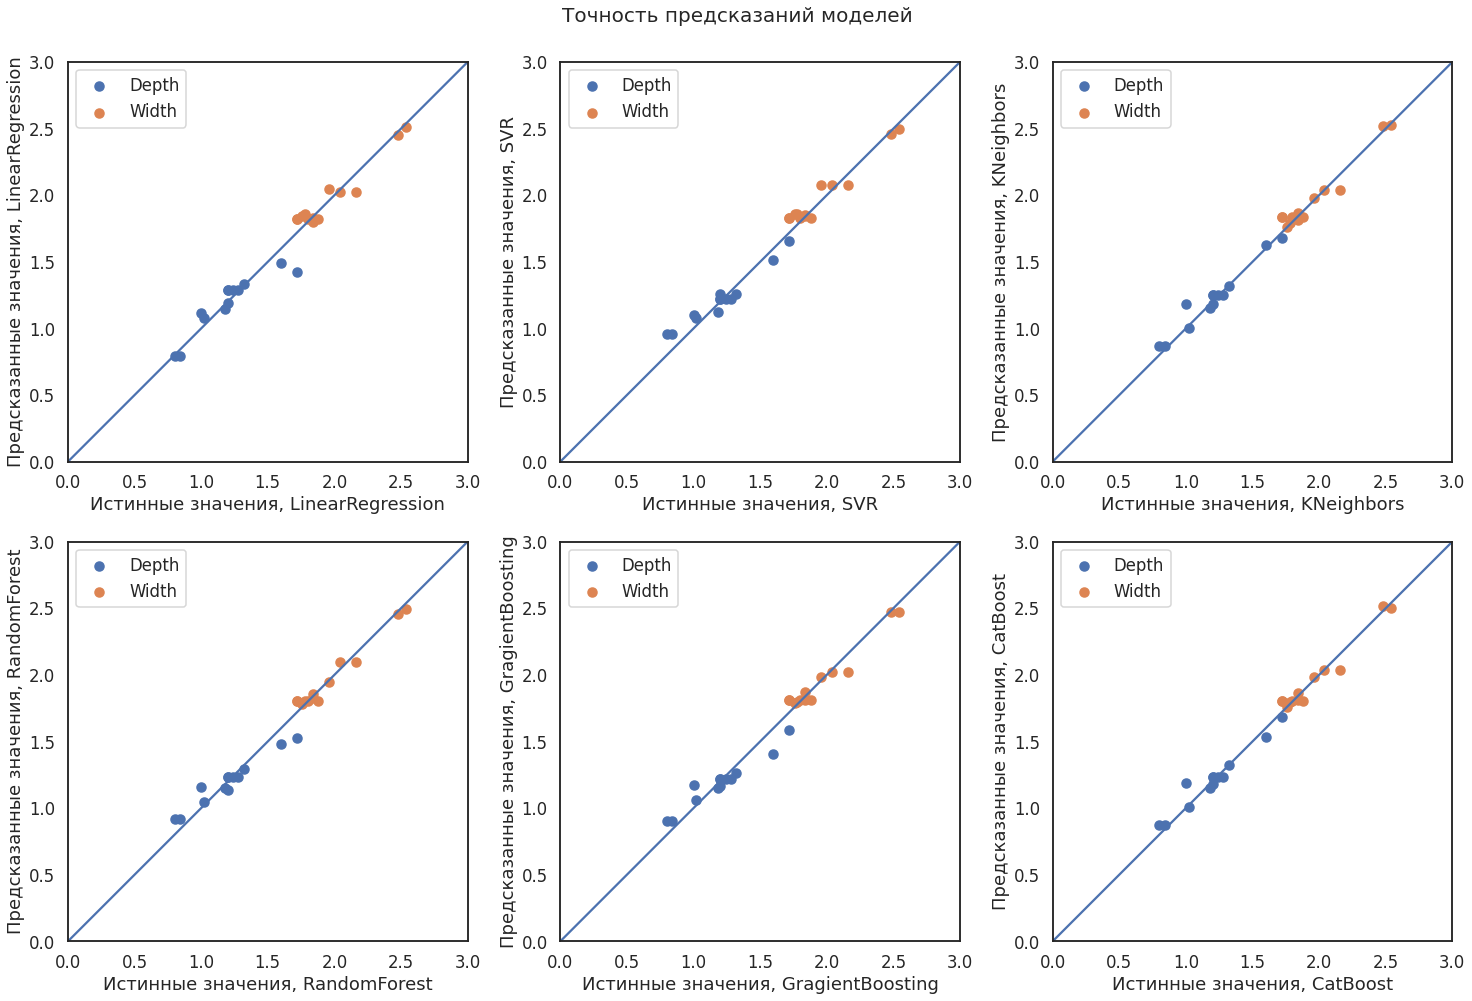

In [50]:
base_models, cv_scores = check_models(X, y, model_pipeline_d, multioutput=False, err=True, n_splits=5, scoring='r2')

Судя по графику, все модели, кроме линейной регрессии, достаточно неплохо справились с задачей. Проверим метрики качества и результаты кросс-валидации.

In [51]:
base_models

,R2_Y_Depth,MSE_Y_Depth,MAE_Y_Depth,R2_Y_Width,MSE_Y_Width,MAE_Y_Width
model,,,,,,
LinearRegression,0.83,0.10,0.07,0.92,0.07,0.06
SVR,0.90,0.08,0.07,0.93,0.07,0.06
KNeighbors,0.94,0.06,0.04,0.95,0.06,0.04
RandomForest,0.87,0.09,0.07,0.97,0.05,0.04
GragientBoosting,0.86,0.09,0.07,0.94,0.06,0.05
CatBoost,0.94,0.06,0.04,0.96,0.06,0.04


In [52]:
cv_scores

,model,target,cv_train_mean,cv_test_mean,cv_train_results,cv_test_results
0,LinearRegression,Depth,0.77,0.69,"[0.7572695972504571, 0.8008186866123927, 0.7546298143146455, 0.7556056487340665, 0.758000564169848]","[0.7470812370023112, 0.45529938650212154, 0.7810405355013514, 0.74977773810085, 0.7150378458971481]"
0,LinearRegression,Width,0.94,0.93,"[0.951699203022226, 0.9449997527203219, 0.9470615506632745, 0.9374788420990644, 0.9396460301146312]","[0.90324396470083, 0.9340436399872679, 0.9001040804271072, 0.9569291774456731, 0.9481986837061829]"
0,SVR,Depth,0.90,0.83,"[0.9087616059323036, 0.8968373891700363, 0.894745729054254, 0.8952956204896271, 0.8892037521534796]","[0.6659789390481852, 0.9181591048221267, 0.7325117136972648, 0.9269385577632844, 0.9053415392650253]"
0,SVR,Width,0.94,0.89,"[0.9403892253327054, 0.9242641820096181, 0.9466494213834404, 0.9562732910527942, 0.9301913001713066]","[0.9505796078353819, 0.9131318066872993, 0.7337060285995127, 0.904770023616404, 0.9450424038770211]"
0,KNeighbors,Depth,0.93,0.89,"[0.8900053229258517, 0.9452086259119112, 0.9375585033344624, 0.9338240864124839, 0.9419594456537149]","[0.969833124418052, 0.7608696986307764, 0.9001405284962731, 0.9451607632676227, 0.8729052950079159]"
0,KNeighbors,Width,0.97,0.95,"[0.9727907823694678, 0.9750145415651829, 0.9789549463562072, 0.9799998272123301, 0.9665541460322216]","[0.9385490394337714, 0.9561996692441121, 0.9430051891722092, 0.9518257660413996, 0.9781495343227185]"
0,RandomForest,Depth,0.92,0.87,"[0.908103526084774, 0.9128491998674083, 0.930316031668741, 0.9331331294249002, 0.9003440407147485]","[0.9146322595456203, 0.8643667412171911, 0.8444353123793639, 0.8314233563626345, 0.9105574722699994]"
0,RandomForest,Width,0.96,0.93,"[0.9577505283259659, 0.9535722190665052, 0.952833705257777, 0.9700566588703715, 0.9618500800970595]","[0.9789617303879353, 0.9589079003009183, 0.9211711454218431, 0.8980096159708238, 0.8815727693066727]"
0,GragientBoosting,Depth,0.93,0.88,"[0.9275958835322089, 0.9344020103246786, 0.9320396925382576, 0.926750668781245, 0.921414386170729]","[0.9120973082155145, 0.7813028207293717, 0.8499364327199015, 0.9302915203182225, 0.9106677093884337]"
0,GragientBoosting,Width,0.97,0.95,"[0.9747992676849163, 0.971573821519828, 0.9690827037937977, 0.9689120329196806, 0.9652967243010154]","[0.9083324135845812, 0.9466081688193022, 0.9669924414676585, 0.9647842488490778, 0.9671180115552652]"


И снова KNeighbors и CatBoost показывают лучшие метрики качества, как итоговые метрики, так и оценки на кросс-валидации, причем CatBoost достаточно хорошо спрогнозировал оба значения.

##### 4.2.1.2 Обучение и оценка моделей на параметрах, подобранных для ширины шва

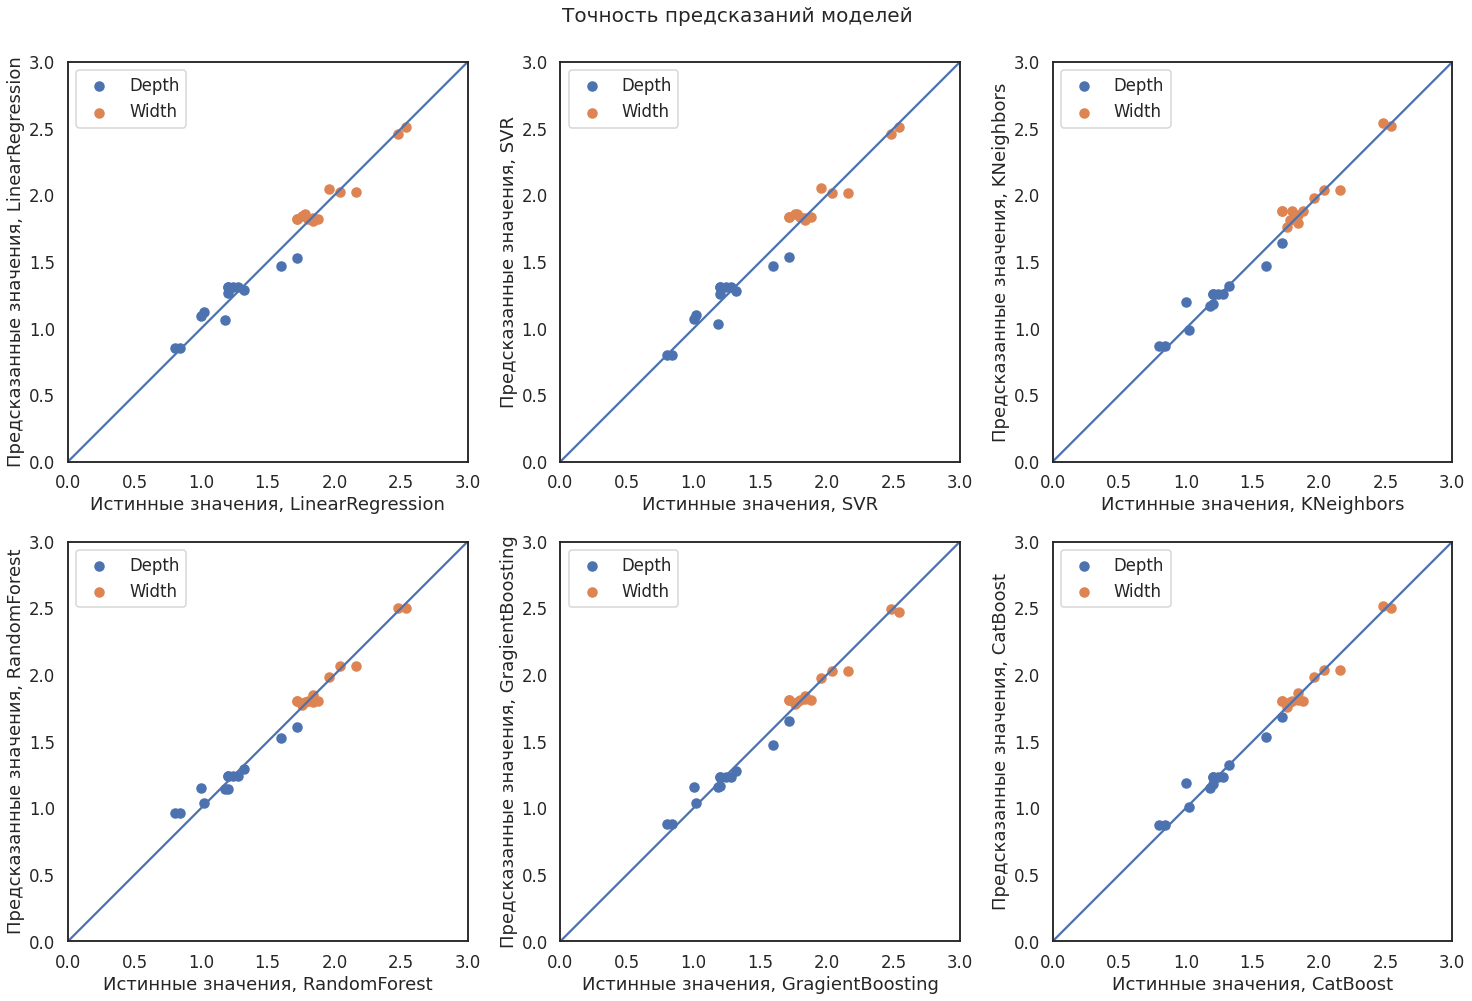

In [53]:
base_models, cv_scores = check_models(X, y, model_pipeline_w, multioutput=False, err=True, n_splits=5, scoring='r2')

Здесь графики показывают, что модели хорошо прогнозируют ширину шва, но хуже - его шлубину. Посмотрим на метрики.

In [54]:
base_models

,R2_Y_Depth,MSE_Y_Depth,MAE_Y_Depth,R2_Y_Width,MSE_Y_Width,MAE_Y_Width
model,,,,,,
LinearRegression,0.84,0.10,0.09,0.93,0.07,0.06
SVR,0.85,0.10,0.08,0.91,0.08,0.06
KNeighbors,0.90,0.08,0.06,0.91,0.08,0.05
RandomForest,0.89,0.08,0.07,0.96,0.05,0.04
GragientBoosting,0.92,0.07,0.06,0.95,0.06,0.04
CatBoost,0.94,0.06,0.04,0.96,0.06,0.04


In [55]:
cv_scores

,model,target,cv_train_mean,cv_test_mean,cv_train_results,cv_test_results
0,LinearRegression,Depth,0.70,0.63,"[0.7423232007283411, 0.6629588993268405, 0.7299302889743, 0.6967296878658542, 0.6715132793171862]","[0.5426296362302248, 0.7902280220103344, 0.37437335407508654, 0.6926034192423817, 0.7671005310461247]"
0,LinearRegression,Width,0.94,0.93,"[0.9355031916308321, 0.9489203918511309, 0.9381472589980501, 0.9440496777468973, 0.9489122943115835]","[0.9656181737545478, 0.8781855623078543, 0.9524783421458595, 0.9242649206876762, 0.916630572810296]"
0,SVR,Depth,0.69,0.45,"[0.7263259713668636, 0.7318986474509339, 0.6655546111879658, 0.6737575474096791, 0.663287392415651]","[0.08943388742086755, 0.21752400980640363, 0.5478281359148238, 0.7341496102184208, 0.6730501447335877]"
0,SVR,Width,0.94,0.93,"[0.941865625692749, 0.9489807913476463, 0.9434444933085188, 0.9390048893468542, 0.9331542027257368]","[0.9428324075213685, 0.888809315257669, 0.9343930947082215, 0.9592300489370128, 0.9263033447633645]"
0,KNeighbors,Depth,0.89,0.85,"[0.896498236531141, 0.9143706657622995, 0.8884986147526279, 0.875289672018205, 0.8789609780277168]","[0.7935059422750427, 0.8937765580736544, 0.8742830942006967, 0.905684134788344, 0.7741199897225072]"
0,KNeighbors,Width,0.97,0.91,"[0.9670063446840614, 0.9684756772573434, 0.9721578791577341, 0.9621119526026793, 0.9737365999839581]","[0.96709747557815, 0.9686081363619873, 0.94607180176432, 0.7079077910709081, 0.937846486316478]"
0,RandomForest,Depth,0.91,0.73,"[0.9036736745246952, 0.9022493395224329, 0.9069224727376802, 0.9394945447753578, 0.9125985472032002]","[0.6462855685784278, 0.9478361110863442, 0.8941913334219106, 0.48797478596451116, 0.6673371350860122]"
0,RandomForest,Width,0.97,0.94,"[0.9652298492118835, 0.9598688659982075, 0.9677991369216415, 0.9686815573843917, 0.9648176399517985]","[0.9414057197512207, 0.9618300255173696, 0.9806895179144802, 0.9236795015085792, 0.9040686645530829]"
0,GragientBoosting,Depth,0.93,0.89,"[0.9308022566725964, 0.915955212089516, 0.9427970816740613, 0.9379530860501081, 0.9353224053144892]","[0.9214452983676051, 0.9380440944222084, 0.822449758755603, 0.8578233505361526, 0.902286547417527]"
0,GragientBoosting,Width,0.97,0.94,"[0.9711026857054768, 0.976819035919723, 0.9659818686339146, 0.975210115814057, 0.970765901769063]","[0.9066312910440799, 0.9514071347603881, 0.9754818801388104, 0.913380094619659, 0.9652416608926396]"


Метрики подтвержают вывод, сделанный выше. С прогнозированием ширины шва все модели справились хорошо. Лучше всех себя показали ансамбли: GradientBoosting и RandomForest.

Прогноз глубины с приемлемым качеством получился только у GradientBoosting.

#### 4.2.2 Обучение на двух таргетах: оценка моделей

##### 4.2.2.1 Обучение и оценка моделей с использованием MultiOutputRegressor

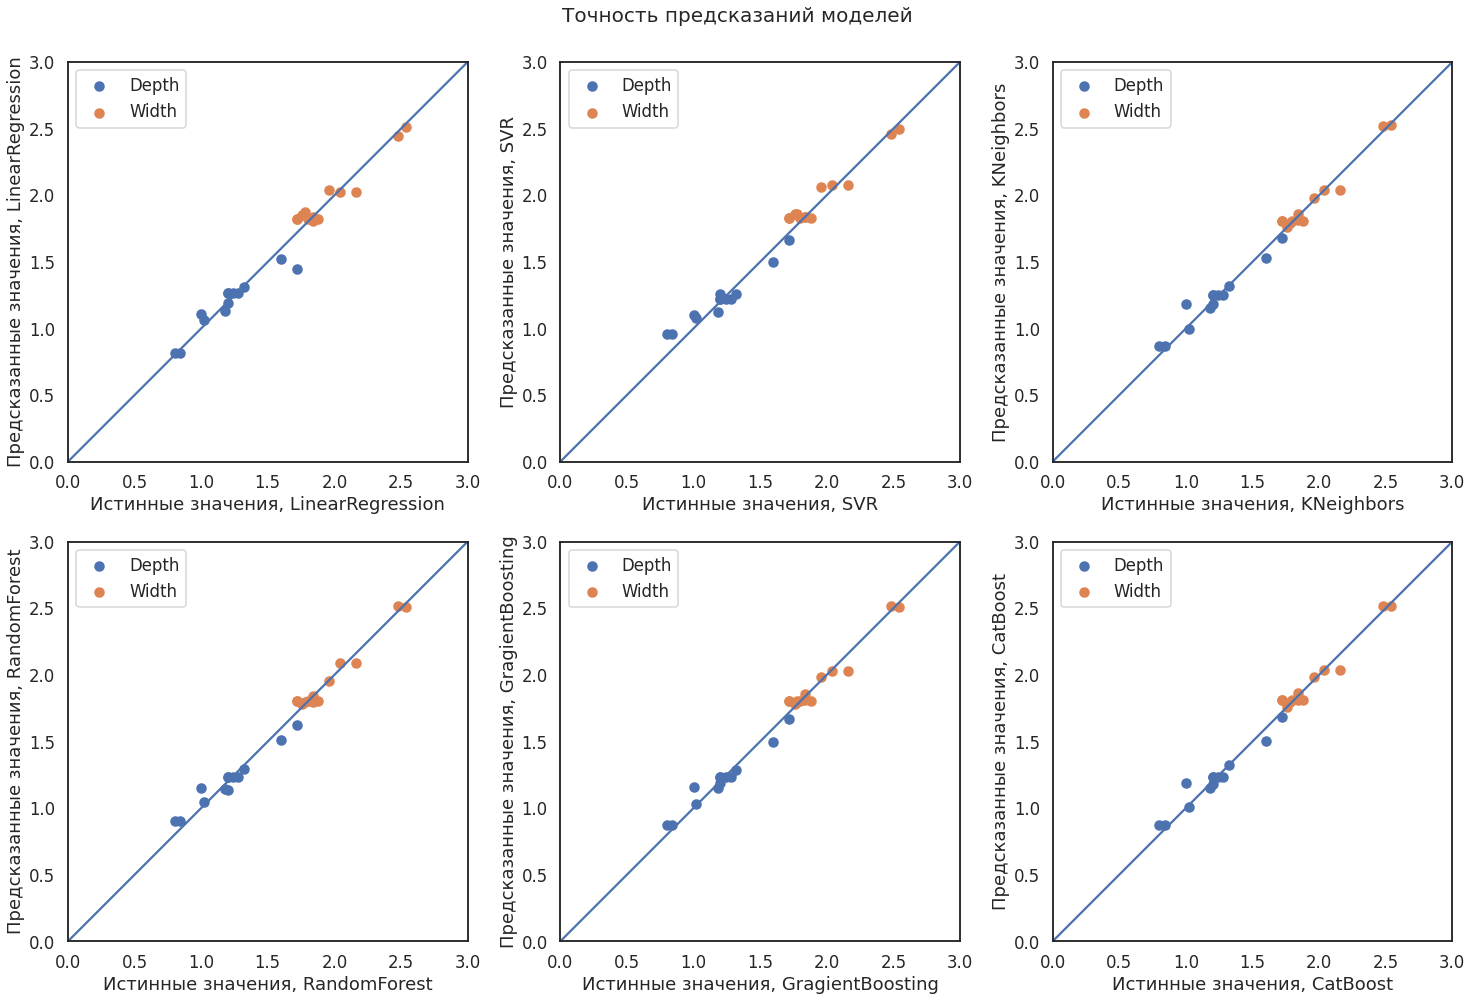

In [57]:
base_models, cv_scores = check_models(X, y, model_pipeline_mor, multioutput=True, err=False, n_splits=5, scoring='r2')

Судя по графикам, модели дают неплохой прогноз. Проверим метрики.

In [58]:
base_models

,R2_Depth,MSE_Depth,MAE_Depth,R2_Width,MSE_Width,MAE_Width
model,,,,,,
LinearRegression,0.87,0.09,0.06,0.92,0.07,0.06
SVR,0.90,0.08,0.07,0.93,0.07,0.06
KNeighbors,0.93,0.06,0.05,0.96,0.05,0.04
RandomForest,0.92,0.07,0.06,0.96,0.05,0.04
GragientBoosting,0.94,0.06,0.05,0.95,0.06,0.04
CatBoost,0.93,0.07,0.05,0.96,0.06,0.04


In [59]:
cv_scores

,model,target,cv_train_mean,cv_test_mean,cv_train_results,cv_test_results
0,LinearRegression,Depth and Width,0.85,0.77,"[0.8617614774603435, 0.8481707255522379, 0.8601859417170811, 0.8246450749586494, 0.8746772344024758]","[0.8024633143400214, 0.7255150399344071, 0.7785922787931093, 0.8805037316584765, 0.6785770819691531]"
0,SVR,Depth and Width,0.92,0.90,"[0.916836510720729, 0.9175274517526786, 0.9264928440652928, 0.9094705786105135, 0.9198609021890596]","[0.9011364458969949, 0.9286743447036957, 0.8712916667770103, 0.9027631693688107, 0.9057675248099724]"
0,KNeighbors,Depth and Width,0.96,0.80,"[0.9615663443238189, 0.9523506326849266, 0.9604478180034788, 0.9468128326675452, 0.9554920413433305]","[0.277532165524225, 0.9363730472270366, 0.9168315793340143, 0.9595130840153909, 0.9248480595652446]"
0,RandomForest,Depth and Width,0.94,0.90,"[0.9474796525898245, 0.9301059175571791, 0.9408973453686658, 0.9484726859347073, 0.9317110629479732]","[0.8760987208162466, 0.9071185404487963, 0.9212901698112741, 0.8652761303887035, 0.9368005984942331]"
0,GragientBoosting,Depth and Width,0.96,0.92,"[0.9447567817983977, 0.9563389154724837, 0.9570043522481859, 0.9617737187553941, 0.9617189647826054]","[0.9656291706547536, 0.9313161994515095, 0.9227820243449432, 0.9142859439422703, 0.8688109840656411]"
0,CatBoost,Depth and Width,0.96,0.91,"[0.9581917354312328, 0.9529552622366554, 0.9520984314034053, 0.9662225805979875, 0.9648599566207197]","[0.9153743965885968, 0.9540816588689643, 0.9538520689244612, 0.8719567065793016, 0.8360224010481871]"


Лучший итоговые метрики и метрики кросс-валидации показали GradientBoosting и CatBoost.

##### 4.2.2.2 Обучение и оценка моделей с использованием RegressorChain

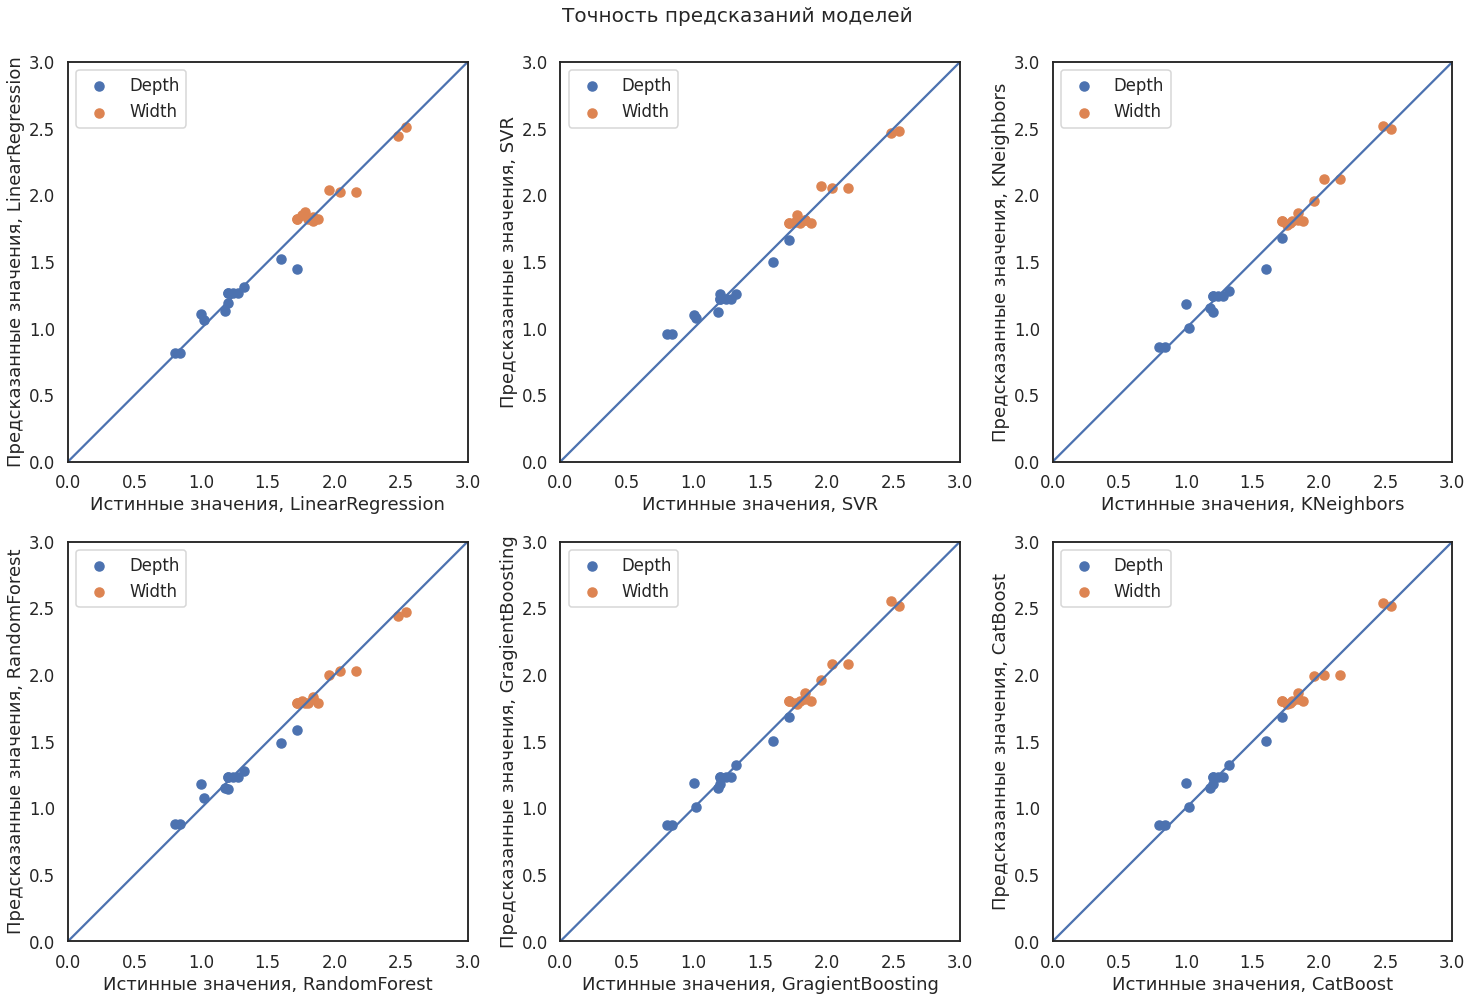

In [60]:
base_models, cv_scores = check_models(X, y, model_pipeline_rc, multioutput=True, err=False, n_splits=5, scoring='r2')

Графики результатов работы Regressor Chain тоже выглдят неплохо, но все же визуально они немного хуже, чем результаты работы MultiOutputRegressor.

Посмотрим на метрики.

In [61]:
base_models

,R2_Depth,MSE_Depth,MAE_Depth,R2_Width,MSE_Width,MAE_Width
model,,,,,,
LinearRegression,0.87,0.09,0.06,0.92,0.07,0.06
SVR,0.90,0.08,0.07,0.94,0.06,0.05
KNeighbors,0.90,0.08,0.06,0.96,0.05,0.04
RandomForest,0.90,0.08,0.07,0.95,0.06,0.05
GragientBoosting,0.93,0.07,0.05,0.96,0.05,0.04
CatBoost,0.93,0.07,0.05,0.94,0.06,0.05


In [62]:
cv_scores

,model,target,cv_train_mean,cv_test_mean,cv_train_results,cv_test_results
0,LinearRegression,Depth and Width,0.85,0.82,"[0.8456503436589609, 0.8656215306625663, 0.8652592534588626, 0.8568370649154331, 0.8406865986040655]","[0.8675311702287801, 0.727274105415924, 0.7984797655690392, 0.8193422403410768, 0.8658285339759116]"
0,SVR,Depth and Width,0.92,0.89,"[0.9219007560288274, 0.9163042796637125, 0.9253724786332884, 0.9262589106172112, 0.9261832826477978]","[0.902814738912954, 0.9339979998393755, 0.9193871952099109, 0.8052312918880891, 0.9121114109624282]"
0,KNeighbors,Depth and Width,0.95,0.90,"[0.9534193440956884, 0.9520495336229111, 0.946984711754196, 0.927567627395947, 0.9527301445628344]","[0.929298274762606, 0.9229384961608631, 0.8547988548625912, 0.8876334176745552, 0.923274425905582]"
0,RandomForest,Depth and Width,0.94,0.90,"[0.9374340365734746, 0.9436354431692568, 0.93862843421359, 0.9492568491909137, 0.9269662148866793]","[0.9015436509196095, 0.8753394766302988, 0.928636716435058, 0.8721082395164103, 0.9118575922234822]"
0,GragientBoosting,Depth and Width,0.95,0.92,"[0.9563762509824696, 0.9516210822553053, 0.9447544014805379, 0.9580032342205806, 0.9503497350130069]","[0.8985048508374947, 0.9255075182439885, 0.9644254807378898, 0.8348530208001117, 0.9548781166452402]"
0,CatBoost,Depth and Width,0.95,0.87,"[0.9436844988361885, 0.9575862547496626, 0.9583816902804281, 0.9491979160770874, 0.9638176092878916]","[0.9449036537579304, 0.9238570177984474, 0.8648589707288704, 0.9436405826142553, 0.6900878666888062]"


Действительно, прогноз моделей достаточно точный, но точность ниже, чем у MultiOutputRegressor. Лучший результат у GradientBoosting.

### 4.3 Обучение и оценка качества моделей, нейронные сети

В качестве нейронных сетей для обучения модели будем использовать многослойный перцептрон из библиотеки SKLearn и полносвязную нейронную сеть, постороенную на фреймвоке Keras библиотеки TensorFlow.

Мы не будем делать подбор параметров для нейронных сетей, начнем сразу с обучения.

При обучении моделей таже будем использовать пайплайн со стандартизацией и снижением размерности.

Для оценки качества моделей будем использовать коэффициент детерминации и кросс-валидацию.

In [63]:
'''
Функция создает слои нейронной сети для последующей подачи в пайплайн машинного обучения.
На вход принимает количество выходов нейронной сети.
'''
def build_model(outputs):
  model = keras.Sequential()
  model.add(Dense(3, input_shape=(3,), activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2),) 
  model.add(Dense(256, activation='relu'),)
  model.add(Dense(outputs))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')
  return model

####4.3.1  Обучение на каждом таргете: оценка моделей

Создадим пайплайн для каждой модели.

In [64]:
models = {
          'MLP': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', MLPRegressor(hidden_layer_sizes=(20, 10, 5, 1), max_iter=1000,
                              learning_rate_init=0.001, random_state=42, solver='lbfgs'))]),
        
          'DenseNN': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', KerasRegressor(model=build_model, outputs=1, epochs=500, verbose=0))])
                 
          }

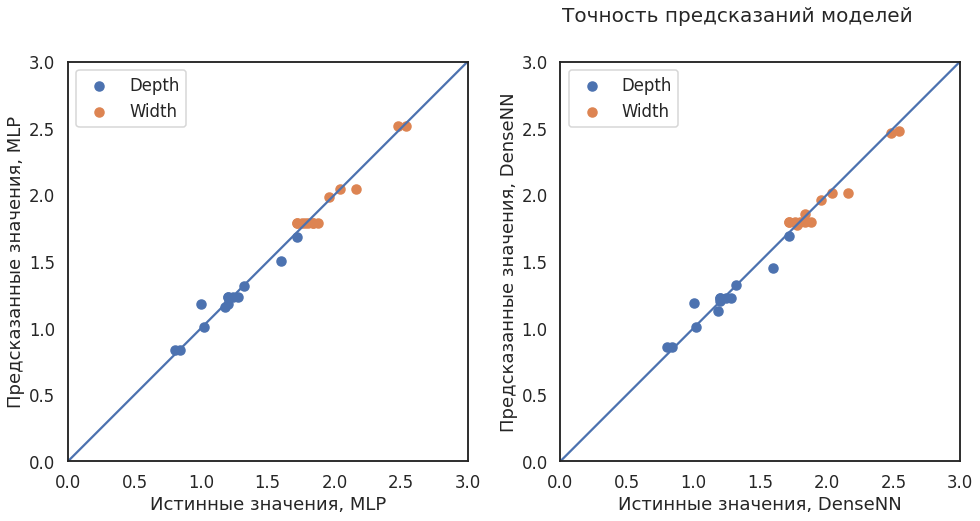

In [65]:
base_models, cv_scores = check_models(X, y, models, multioutput=False, err=False, n_splits=3, scoring='r2')

Как видно из графиков, многослойный перцептрон справился с задачей предсказания плохо. Он выдает практически одни и те же предсказания для некоторых значений ширины шва. 

Результаты предсказний полносвязной сети тоже не внушают оптимизма.

Посмотрим итоговые метрики.

In [66]:
base_models

,R2_Y_Depth,MSE_Y_Depth,MAE_Y_Depth,R2_Y_Width,MSE_Y_Width,MAE_Y_Width
model,,,,,,
MLP,0.94,0.06,0.04,0.96,0.06,0.04
DenseNN,0.92,0.07,0.05,0.94,0.06,0.05


In [67]:
cv_scores

,model,target,cv_train_mean,cv_test_mean,cv_train_results,cv_test_results
0,MLP,Depth,0.94,0.90,"[0.9493445757504043, 0.9516834510695517, 0.9249650321796982]","[0.8760064719007576, 0.8799383864418794, 0.9406430586898044]"
0,MLP,Width,0.71,0.66,"[0.9713630936001295, 0.9768591131384702, 0.1732857944848053]","[0.9483180211256818, 0.9475540689578746, 0.0874317130598955]"
0,DenseNN,Depth,0.91,0.82,"[0.8870688711532175, 0.8948484347236405, 0.9363852748686896]","[0.8720007203288371, 0.7236977006228582, 0.8608397704678862]"
0,DenseNN,Width,0.97,0.95,"[0.9712631295412095, 0.9640596179169135, 0.9647717517694855]","[0.9267676689462383, 0.9467660903885804, 0.9700134493701013]"


Итоговая метрика перцептрона выглядит многообещающе, однако результаты кросс-валидации показывают, что не стоит обольщаться. 

Можно сделать вывод, что с задачей прогнозирования глубины сварного шва лучше справился многослойный перцептрон, а в прогнозировании ширины сварного шва результаты лучше у полносвязной нейронной сети.

####4.3.2  Обучение на двух таргетах: оценка моделей

In [68]:
models = {
          'MLP': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', MLPRegressor(hidden_layer_sizes=(20, 10, 5, 2), max_iter=1000,
                              learning_rate_init=0.001, random_state=42, solver='lbfgs'))]),
        
          'DenseNN': Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=3)),
                 ('model', KerasRegressor(model=build_model, outputs=2, epochs=500, verbose=0))])
                 
          }

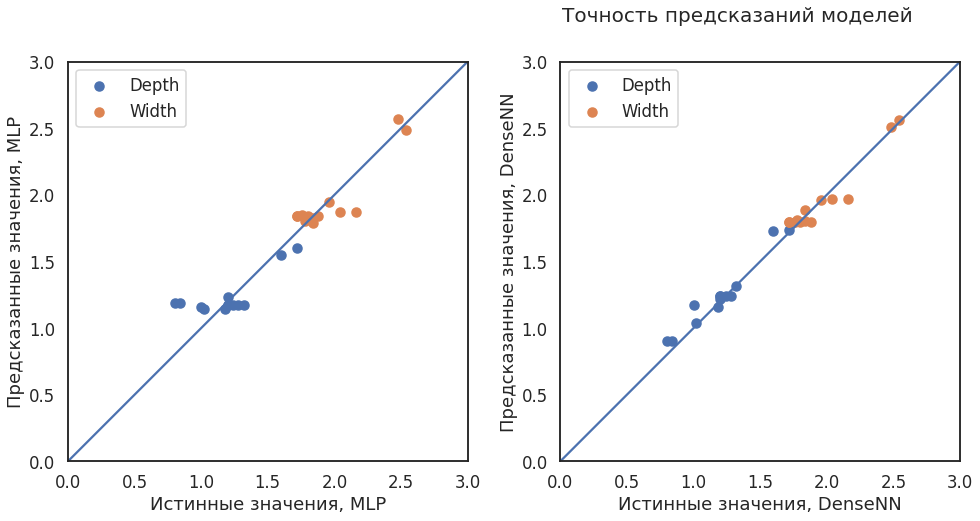

In [69]:
base_models, cv_scores = check_models(X, y, models, multioutput=True, err=True, n_splits=3, scoring='r2')

Как видим, и в этом случае многослойный перцептрон дает некорректные предсказания. Результаты полносвязной нейронной сети выглядят неплохо.

In [70]:
base_models

,R2_Depth,MSE_Depth,MAE_Depth,R2_Width,MSE_Width,MAE_Width
model,,,,,,
MLP,0.55,0.17,0.13,0.81,0.11,0.09
DenseNN,0.92,0.07,0.05,0.93,0.07,0.05


In [71]:
cv_scores

,model,target,cv_train_mean,cv_test_mean,cv_train_results,cv_test_results
0,MLP,Depth and Width,0.69,0.53,"[0.6880250602448343, 0.7244677954925629, 0.6442212890850665]","[0.36208171904533243, 0.5353965191131076, 0.6831250492406034]"
0,DenseNN,Depth and Width,0.93,0.81,"[0.9467560365251599, 0.9340368117773071, 0.9223137583659293]","[0.8707889165929757, 0.7465776480945882, 0.8138710131523387]"


Полносвязная нейронная сеть показала приемлемые результаты на кросс-валидации. Мнгослойный перцептрон с задачей прогнозирования не справился.

Таким образом, можно сделать вывод, что нейронные сети не очень хорошо подходят для решения поставленной задачи.

### 4.4 Выбор модели для создания приложения

По итогам оценки моделей можно сказать, что с задачей лучше всего справились модели KNeighbors, GradientBoosting и CatBoost. 

Для дальнейшего вывода в продакшн будем использовать модель GradientBoosting Regressor с MultiOutputRegressor, т.к. она не только показала хороший результат прогнозирования двух переменных, но и входит в библиотеку SKLearn, т.е. для ее хранения на хостинге потребуется меньше места. 

Значения коэффициента детерминации для выбранной модели: 0,94 для глубины шва и 0,95 для ширины шва. Средняя оценка качества для двух метрик на кросс-валидации составила 0,96 на тренировочном наборе данных и 0,92 на тестовом наборе данных.

Перед тем, как сохранить модель, обучим ее еще раз на всех данных.

In [73]:
gb = Pipeline(steps=[('scale', StandardScaler()),
                 ('reduce_dims', PCA(n_components=2)),
                 ('model',
                  MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                           max_features='auto',
                                                                           min_samples_split=7,
                                                                           n_estimators=500,
                                                                           random_state=42)))])

In [74]:
gb.fit(X, y) 

Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=2)),
                ('model',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                          max_features='auto',
                                                                          min_samples_split=7,
                                                                          n_estimators=500,
                                                                          random_state=42)))])

Сохраним полученную модель для последующего развертывания в виде приложения Flask в интернете.

In [78]:
pickle.dump(gb, open('gb_model.pkl', 'wb'))

## Вывод

Целью проекта являлось построение модели машинного обучения для прогнозирования параметров глубины и ширины сварного шва.

Перед построением модели машинного обучения была проведена предобработка данных, удалены дубликаты.

Затем был проведен исследовательский анализ данных, в котором были выявлены нелинейные корреляции между признаками и таргетами, а также корреляции признаков между собой. По итогам этапа был сделан вывод, что таргеты хорошо поддаются прогнозированию, а также что для успешного прогнозирования можно использовать не все признаки.

После этого был построен пайплайн машинного обучения:
- нормализация входящих признаков;
- сокращение числа входных признаков с помощью метода главных компонент;
- подача подготовленных признаков в модель машинного обучения.

Затем был произведен подбор оптимальных параметров для выбранных моделей с помощью поиска по сетке и кросс-валидации:
- линейная регрессия;
- SVR;
- KNeighbors;
- RandomForest;
- GradientBoosting;
- CatBoost.

Также для оценки использовались две нейронные сети: многослойный перцептрон и полносвязная нейронная сеть на 3 скрытых слоя.

После этого модели были обучены, и качество их прогнозов проверено на кросс-валидации. По итогам оценки для последующего развертывания в виде приложения была выбрана модель GradientBoosting Regressor с MultiOutputRegressor. Значения коэффициента детерминации для выбранной модели: 0,94 для глубины шва и 0,95 для ширины шва. Средняя оценка качества для двух метрик на кросс-валидации составила 0,96 на тренировочном наборе данных и 0,92 на тестовом наборе данных.